## Reward prediction error

Assume reward can be predicted linearly from instantainous input
$$\hat{R} = WI + b$$
We will not model any reward prediction neurons, as they are not strictly necessary. Instead, we will directly model the reward prediction error neurons
$$\tau_\epsilon \dot{\epsilon} = -\epsilon + \sigma(R - WI - b)$$
So if $\epsilon > 0.5$, there is more reward than predicted, otherwise less. The perfect predictor would result in $\epsilon=0.5$ always. This induces a loss function
$$L_2^2 = |\epsilon - 0.5|^2$$
The predicting weights and biases $W, b$ can be trained by SGD of the above loss function. This results in the equations
$$\tau_W \dot{W}_i = (\epsilon - 0.5)\sigma' I_i$$
$$\tau_b \dot{b} = (\epsilon - 0.5)\sigma'$$

**Concerns**:
* Is baseline plasticity really necessary? It seems to be almost 0. Try exclude. Try to fiddle with input, having different mean between textures
* Currently weights are allowed to be negative, and they take advantage of that. Extend the model by adding inhibitory neurons and explicitly forbidding weights to go negative

In [1]:
import numpy as np
import matplotlib.pyplot as plt

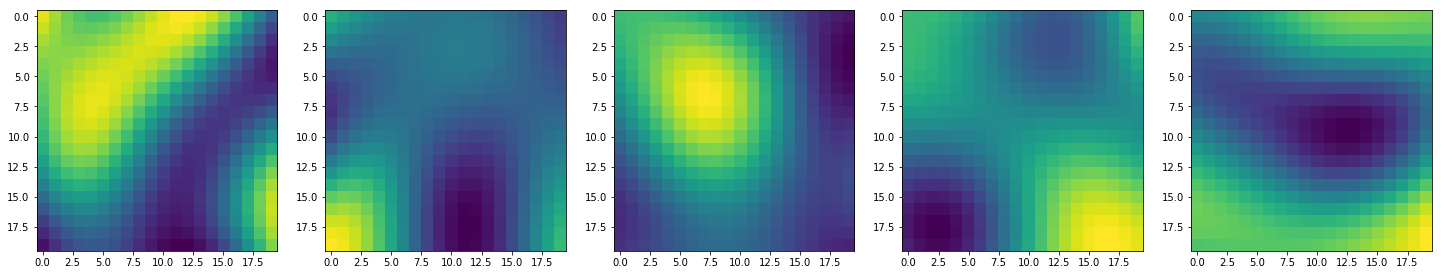

In [2]:
# Generate a bunch on random images using truncated 2D fourier basis with random coefficients
# All pixel values are non-negative
def genRandomImg(NX, NY):
    img = np.zeros((NX, NY))
    xx = np.array([[i for j in range(NY)] for i in range(NX)])
    yy = np.array([[j for j in range(NY)] for i in range(NX)])
    for i in range(-2, 2):
        for j in range(-2, 2):
            kx = i / NX / 2
            ky = j / NY / 2
            r0, phi0 = np.random.uniform(0, 1, 2)
            phi = kx*xx + ky*yy - phi0
            img += r0 * np.cos(2 * np.pi * phi)
            img += r0 * np.sin(2 * np.pi * phi)
    
    img -= np.min(img)
    img /= np.linalg.norm(img)
    return img

##################################
# Generate some random pictures
##################################
N_IMAGES = 5
NPIX_ROW = 20
NPIX_COL = 20

images = [genRandomImg(NPIX_ROW, NPIX_COL) for i in range(N_IMAGES)]

fig, ax = plt.subplots(ncols=N_IMAGES, figsize=(5*N_IMAGES, 5))
for i in range(N_IMAGES):
    ax[i].imshow(images[i])
plt.show()

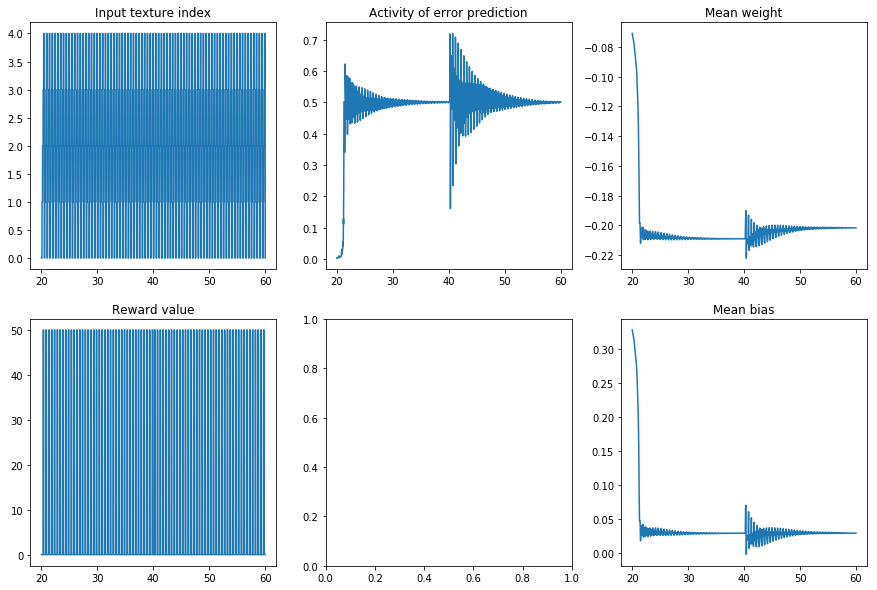

In [3]:
def sig_sigprim(x, x0):
    e = np.exp(-x/x0)

    return 1 / (1 + e), e/x0/(1+e)**2

def RHS_EWB(I, R, E, W, b, p):
    Ieff = R - W.dot(I) - b
    s, s2 = sig_sigprim(Ieff, p['V_slope'])
    rhs_e = (s - E) / p['tau_e']
    rhs_w = (E - 0.5)*s2*I / p['tau_w']
    rhs_b = (E - 0.5)*s2 / p['tau_b']
    return rhs_e, rhs_w, rhs_b

param = {
    'tau_e' : 1,       # ms, neuronal response time
    'tau_w' : 2,      # ms, synaptic plasticity
    'tau_b' : 2,      # ms, synaptic plasticity
    'V_slope' : 50,    # mV, sigmoid slope
    'V_noise' : 50,    # mV, noise magnitude
    'V_input' : 50,    # mV, input magnitude
    'dt'      : 0.1,   # ms, discretization time
    'T'       : 60000,  # ms, simulation time
    'T_reverse' : 40000,  # ms, time to switch reward
    'T_swap'  : 100,   # ms, time to swap picture
}

T_STEP = int(param['T'] / param['dt']) + 1
t_list = np.linspace(0, param['T'], T_STEP)

idx_pic = (t_list / param['T_swap']).astype(int) % 5
idx_rev = int(param['T_reverse'] / param['dt'])
reward = np.zeros(T_STEP)
reward[:idx_rev] = param['V_input']*(idx_pic[:idx_rev] == 3).astype(float)
reward[idx_rev:] = param['V_input']*(idx_pic[idx_rev:] == 2).astype(float)

N_PIX = NPIX_ROW*NPIX_COL
W_hist = np.zeros(T_STEP)
W = np.random.uniform(0, 1, N_PIX)
W_hist[0] = np.mean(W)
b = np.zeros(T_STEP)
b[0] = 0
E = np.zeros(T_STEP)
E[0] = 0.5

for i in range(1, T_STEP):
    I = images[idx_pic[i]].flatten() * param['V_input']
    R = reward[i]
    VE, VW, VB = RHS_EWB(I, R, E[i-1], W, b[i-1], param)
    E[i] = E[i-1] + VE*param['dt']
    W = W + VW*param['dt']
    b[i] = b[i-1] + VB*param['dt']
    W_hist[i] = np.mean(W)

T_ST = 200000

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15,10))
ax[0][0].plot(t_list[T_ST:] / 1000, idx_pic[T_ST:])
ax[1][0].plot(t_list[T_ST:] / 1000, reward[T_ST:])
ax[0][1].plot(t_list[T_ST:] / 1000, E[T_ST:])
ax[0][2].plot(t_list[T_ST:] / 1000, b[T_ST:])
ax[1][2].plot(t_list[T_ST:] / 1000, W_hist[T_ST:])

ax[0][0].set_title("Input texture index")
ax[1][0].set_title("Reward value")
ax[0][1].set_title("Activity of error prediction")
ax[0][2].set_title("Mean weight")
ax[1][2].set_title("Mean bias")
plt.show()

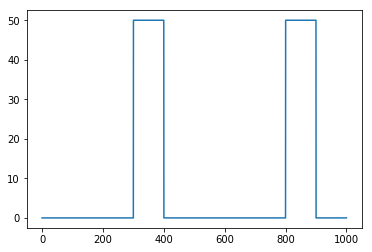

In [0]:
plt.figure()
plt.plot(t_list[:10000], reward[:10000])
plt.show()